In [1]:
!python --version

Python 3.8.13


In [2]:

import os
import cv2
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model



CLASSES = ("MildDemented", "NonDemented", "VeryMildDemented")
DATASET_DIR = "data/"
TEST_DIR = DATASET_DIR + "test/"
TRAINING_DIR = DATASET_DIR + "train/"

IMG_SIZE = 100

def create_data(directory):
    data = []
    for CLASSE in CLASSES:
        path = os.path.join(directory, CLASSE)
        class_num = CLASSES.index(CLASSE)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append((img_array, class_num))
            
    return data

train_data = create_data(TRAINING_DIR)
test_data = create_data(TEST_DIR)

random.shuffle(train_data)
random.shuffle(test_data)

def prepare_data(data):
    inp = []
    out = []
    
    for img, label in data:
        inp.append(img)
        y = np.zeros(len(CLASSES))
        y[label] = 1
        out.append(y)
    inp = np.array(inp).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
    return inp, out

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train = X_train / 255
y_train = np.array(y_train)

X_test = X_test / 255
y_test = np.array(y_test)

for classe in CLASSES:
    class_num = CLASSES.index(classe)
    print(classe, class_num)


100%|██████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 2051.13it/s]


MildDemented 0
NonDemented 1
VeryMildDemented 2


Text(0.5, 0, 'Mild Demented')

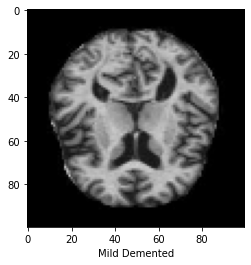

In [3]:
plt.imshow(X_train[6:7][0,:,:,:])
plt.xlabel("Mild Demented")

Text(0.5, 0, 'Very Mild Demented')

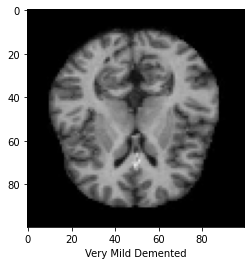

In [4]:
plt.imshow(X_train[37:38][0,:,:,:])
plt.xlabel("Very Mild Demented")

Text(0.5, 0, 'Non Demented')

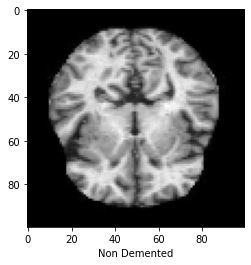

In [5]:
plt.imshow(X_train[65:66][0,:,:,:])
plt.xlabel("Non Demented")

In [6]:
X_train.shape[1:]

(100, 100, 3)

In [10]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', name='last_conv_layer'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')], name='modelv1')

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

model.summary()


Model: "modelv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 49, 49, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 23, 23, 64)       0         
 ePooling2D)                                                     
                                                           

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1)

Epoch 1/100
143/143 [==============================] - 29s 186ms/step - loss: 1.2997 - acc: 0.4873 - prec: 0.5156 - rec: 0.4244 - auc: 0.6878 - val_loss: 1.4237 - val_acc: 0.1460 - val_prec: 0.1462 - val_rec: 0.1460 - val_auc: 0.3533
Epoch 2/100
143/143 [==============================] - 28s 194ms/step - loss: 0.9293 - acc: 0.5412 - prec: 0.6198 - rec: 0.4049 - auc: 0.7465 - val_loss: 1.0714 - val_acc: 0.3452 - val_prec: 1.0000 - val_rec: 0.0039 - val_auc: 0.6481
Epoch 3/100
143/143 [==============================] - 28s 195ms/step - loss: 0.9024 - acc: 0.5355 - prec: 0.6499 - rec: 0.3678 - auc: 0.7488 - val_loss: 0.8576 - val_acc: 0.5464 - val_prec: 0.7251 - val_rec: 0.3590 - val_auc: 0.7639
Epoch 4/100
143/143 [==============================] - 29s 205ms/step - loss: 0.8595 - acc: 0.5669 - prec: 0.7045 - rec: 0.3674 - auc: 0.7692 - val_loss: 1.1065 - val_acc: 0.3432 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.4797
Epoch 5/100
143/143 [==============================] - 2

Epoch 36/100
143/143 [==============================] - 30s 207ms/step - loss: 0.0350 - acc: 0.9890 - prec: 0.9890 - rec: 0.9882 - auc: 0.9989 - val_loss: 0.2144 - val_acc: 0.9448 - val_prec: 0.9444 - val_rec: 0.9389 - val_auc: 0.9865
Epoch 37/100
143/143 [==============================] - 31s 215ms/step - loss: 0.0584 - acc: 0.9840 - prec: 0.9849 - rec: 0.9838 - auc: 0.9977 - val_loss: 0.9409 - val_acc: 0.7199 - val_prec: 0.7237 - val_rec: 0.7179 - val_auc: 0.9043
Epoch 38/100
143/143 [==============================] - 28s 195ms/step - loss: 0.0212 - acc: 0.9939 - prec: 0.9941 - rec: 0.9936 - auc: 0.9996 - val_loss: 2.3521 - val_acc: 0.6627 - val_prec: 0.6627 - val_rec: 0.6588 - val_auc: 0.8085
Epoch 39/100
143/143 [==============================] - 28s 195ms/step - loss: 0.0457 - acc: 0.9873 - prec: 0.9879 - rec: 0.9866 - auc: 0.9981 - val_loss: 0.0687 - val_acc: 0.9822 - val_prec: 0.9822 - val_rec: 0.9803 - val_auc: 0.9974
Epoch 40/100
143/143 [==============================] - 29s 

Epoch 71/100
143/143 [==============================] - 29s 204ms/step - loss: 0.0429 - acc: 0.9873 - prec: 0.9882 - rec: 0.9871 - auc: 0.9990 - val_loss: 0.6991 - val_acc: 0.8501 - val_prec: 0.8563 - val_rec: 0.8462 - val_auc: 0.9447
Epoch 72/100
143/143 [==============================] - 29s 199ms/step - loss: 0.0199 - acc: 0.9939 - prec: 0.9941 - rec: 0.9934 - auc: 0.9996 - val_loss: 0.2479 - val_acc: 0.9566 - val_prec: 0.9566 - val_rec: 0.9566 - val_auc: 0.9825
Epoch 73/100
143/143 [==============================] - 28s 199ms/step - loss: 0.0259 - acc: 0.9930 - prec: 0.9934 - rec: 0.9930 - auc: 0.9988 - val_loss: 0.5795 - val_acc: 0.8915 - val_prec: 0.8911 - val_rec: 0.8876 - val_auc: 0.9652
Epoch 74/100
143/143 [==============================] - 29s 201ms/step - loss: 0.0255 - acc: 0.9919 - prec: 0.9921 - rec: 0.9915 - auc: 0.9993 - val_loss: 0.0955 - val_acc: 0.9744 - val_prec: 0.9744 - val_rec: 0.9744 - val_auc: 0.9946
Epoch 75/100
143/143 [==============================] - 31s 

In [25]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))

40/40 [==============================] - 2s 39ms/step - loss: 2.3842 - acc: 0.7301 - prec: 0.7323 - rec: 0.7190 - auc: 0.8355
Testing Accuracy: 96.05%
Testing Precision: 94.03%
Testing Recall: 94.56%
Testing AUC: 95.59%


In [26]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

40/40 [==============================] - 2s 38ms/step


In [27]:
cm

array([[ 55,  58,  66],
       [  0, 521, 119],
       [  3,  96, 349]], dtype=int64)

In [29]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 89   0   0]
 [  0 315   5]
 [  0   1 223]]


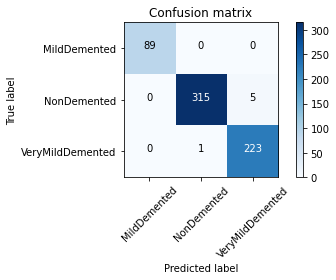

In [30]:
plot_confusion_matrix(cm, CLASSES, normalize=False)

In [18]:
biclass = ['NON_DEMENTED', 'DEMENTED']

bicm = np.array([[315, 5],
         [1,89 + 223]])

Normalized confusion matrix
[[0.984375   0.015625  ]
 [0.00319489 0.99680511]]


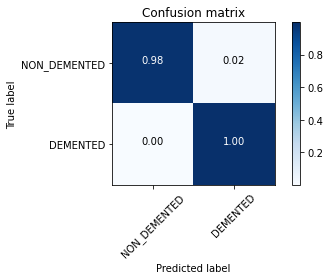

In [19]:
plot_confusion_matrix(bicm, biclass, normalize=True)